# Binance Data Source Review

This notebook documents the accumulation of real-time data by connecting to the Binance Websocket.

## Objective
The goal is to accumulate real-time data of the crypto tickers via Binance by connecting to its Websocket and getting a stream of trades. We then want to save these trades for future reference across the project.

In [1]:
import matplotlib.pyplot as plt
import websockets
import json
from datetime import datetime
import csv
from pathlib import Path
import pandas as pd
import duckdb

SYMBOLS = ["btcusdt", "xrpusdt"]
BINANCE_WS_URL = "wss://stream.binance.com:9443/stream?streams=btcusdt@trade/xrpusdt@trade"

In [2]:
async def stream_prices():
    count = 0
    async with websockets.connect(BINANCE_WS_URL) as ws:
        print(f" Connected to Binance WebSocket\nTracking: {', '.join(SYMBOLS).upper()}")
        while True:
            try:
                msg = await ws.recv()
                data = json.loads(msg)

                payload = data['data']
                symbol = payload['s']
                price = float(payload['p'])
                timestamp = datetime.utcfromtimestamp(payload['T'] / 1000)

                print(f"{timestamp:%F %T} | {symbol} -> {price:>12g}")
                count+=1
                if count >= 10:
                    break
            except Exception as e:
                print(f" Error: {e}")
                break


In [6]:
await stream_prices()

 Connected to Binance WebSocket
Tracking: BTCUSDT, XRPUSDT
2025-07-05 22:57:13 | BTCUSDT ->       108186
2025-07-05 22:57:14 | BTCUSDT ->       108186
2025-07-05 22:57:14 | BTCUSDT ->       108186
2025-07-05 22:57:14 | XRPUSDT ->       2.2162
2025-07-05 22:57:14 | XRPUSDT ->       2.2162
2025-07-05 22:57:14 | XRPUSDT ->       2.2162
2025-07-05 22:57:14 | XRPUSDT ->       2.2162
2025-07-05 22:57:14 | XRPUSDT ->       2.2162
2025-07-05 22:57:14 | XRPUSDT ->       2.2162
2025-07-05 22:57:14 | XRPUSDT ->       2.2162


We need to connect to the Websocket using this specific URL so that we can get a stream of BTC and XRP trades. Through that stream we extract the payload of each trade. We can nicely visualise this. The count is added only for production purposes to illustrate the workflow.

In [39]:
logfile = (Path.cwd().parent.parent / "src" / "data" / "binance_prices.csv").resolve()

async def stream_prices():
    async with websockets.connect(BINANCE_WS_URL) as ws:
        while True:
            msg = await ws.recv()
            wrapper = json.loads(msg)
            trade = wrapper["data"]

            timestamp = datetime.utcfromtimestamp(trade['T'] / 1000)
            ts = f"{timestamp:%F %T}"
            symbol = trade["s"]
            price = float(trade["p"])
            qty = float(trade["q"])

            with open(logfile, mode="a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([ts, symbol, price, qty])

In [21]:
trades = pd.read_csv(logfile)
trades.sample(10)

,timestamp,symbol,price,quantity,trade_id
4,2025-07-06 13:39:10,BTCUSDT,108600.6700,0.00002,5065509945
1,2025-07-06 13:39:09,XRPUSDT,2.2769,439.10000,1204417260
8,2025-07-06 13:39:11,XRPUSDT,2.2768,2.90000,1204417261
6,2025-07-06 13:39:10,BTCUSDT,108600.6800,0.00317,5065509947
9,2025-07-06 13:39:11,BTCUSDT,108600.6700,0.00003,5065509949
2,2025-07-06 13:39:10,BTCUSDT,108600.6700,0.00005,5065509943
12,2025-07-06 13:39:11,BTCUSDT,108600.6700,0.00008,5065509952
3,2025-07-06 13:39:10,BTCUSDT,108600.6700,0.00005,5065509944
0,2025-07-06 13:39:09,XRPUSDT,2.2769,35.10000,1204417259
11,2025-07-06 13:39:11,BTCUSDT,108600.6800,0.00008,5065509951


Here we write the stream of data to a csv file. We keep track of the payload of each trade. This is a random sample of the data stream saved to a file by running the function stream_prices() for a few seconds. This data will be used later once we have gathered data from all sources.

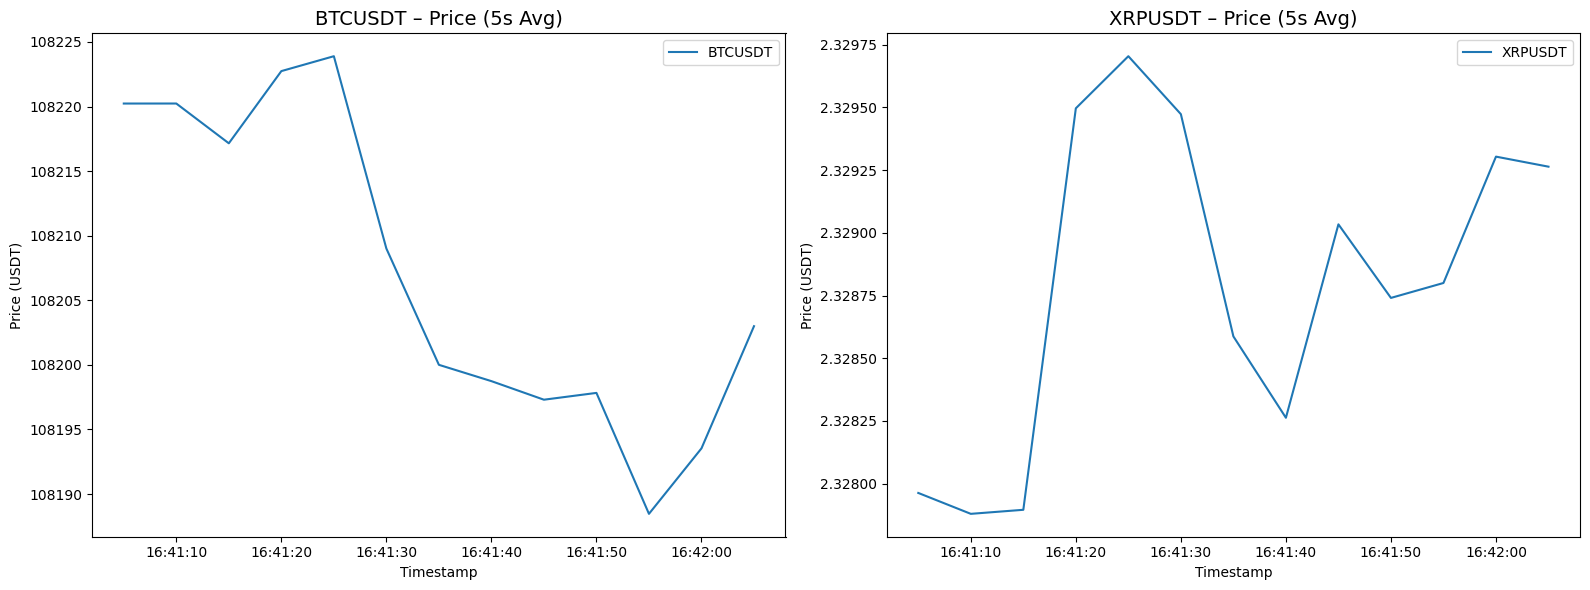

In [45]:
df = pd.read_csv(logfile, parse_dates=["timestamp"])
df.sort_values("timestamp", inplace=True)
df.set_index("timestamp", inplace=True)
resampled = df.groupby("symbol").resample("5s").agg({"price": "mean"}).reset_index()
symbols = resampled["symbol"].unique()

fig, axes = plt.subplots(1, len(symbols), figsize=(8 * len(symbols), 6), sharex=False)

for ax, symbol in zip(axes, symbols):
    data = resampled[resampled["symbol"] == symbol]
    ax.plot(data["timestamp"], data["price"], label=symbol)
    ax.set_title(f"{symbol} – Price (5s Avg)", fontsize=14)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price (USDT)")
    ax.legend()

plt.tight_layout()
plt.show()

We are able to plot a graph from the data saved in the csv file. We take the 5s average as there are many concurrent trades at different prices which adds a bit of noise to the graph which is also due to the sample rate (we have bursts of each ticker).

## Saving to DuckDB

In [3]:
DB_PATH = (Path.cwd().parent.parent / "src" / "data" / "market_attention.duckdb").resolve()
con = duckdb.connect(DB_PATH)

async def stream_prices():
    async with websockets.connect(BINANCE_WS_URL) as ws:
        while True:
            ticker, price, quantity, ts = None, None, None, None
            # ...
            # ...
            # ...
            con.execute("""
                INSERT INTO prices (ticker, price, quantity, timestamp)
                VALUES (?, ?, ?, ?)
                """, (ticker, float(price), float(quantity), ts))
con.close()

Here we switch to DuckDB from a CSV file, like this we can keep the data more well maintained in tables and use joins for complex queries.